## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file
with open('/content/complaints-2021-05-14_08_16.json') as f:
    data = json.load(f)

# returns JSON object as a dictionary
df = pd.json_normalize(data)
df

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

In [25]:
df['complaint_what_happened'].replace('', np.nan, inplace=True)


/tmp/ipython-input-4227691844.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)
df['complaint_what_happened']

,complaint_what_happened
0,NaN
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,NaN
4,NaN
...,...
78308,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...


In [ ]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
df

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [ ]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
#Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # 1. Make text lowercase
    text = text.lower()

    # 2. Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['clean_complaint'] = df['complaint_what_happened'].apply(clean_text)
df['clean_complaint'].head()

,clean_complaint
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [ ]:
# Apply the clean_text function to the first complaint and print the result
text = df['complaint_what_happened'].iloc[0]
cleaned_text = clean_text(text)
cleaned_text
# print(cleaned_text)

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [ ]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

lemmatize_text(text)

'good morning my name be XXXX xxxx and I appreciate it if you could help I put a stop to Chase Bank cardmember service . \n in 2018 I write to Chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .'

In [24]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()
df_clean['complaint'] = df['complaint_what_happened'].apply(clean_text)
df_clean['lemmatized_complaint'] = df_clean['complaint'].apply(lemmatize_text)

In [26]:
df_clean

,complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [28]:
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


In [27]:
  #Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  doc = nlp(text)
  tagged_text = " ".join([token.text for token in doc if token.tag_ == "NN"])
  return tagged_text

df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaint'].apply(pos_tag)

In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card chase freedom problem...


In [30]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,clean_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [31]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Histogram of complaint character length
fig = px.histogram(df_clean['complaint'].str.len(),
                   title='Distribution of Complaint Character Length',
                   labels={'value': 'Character Length'})
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

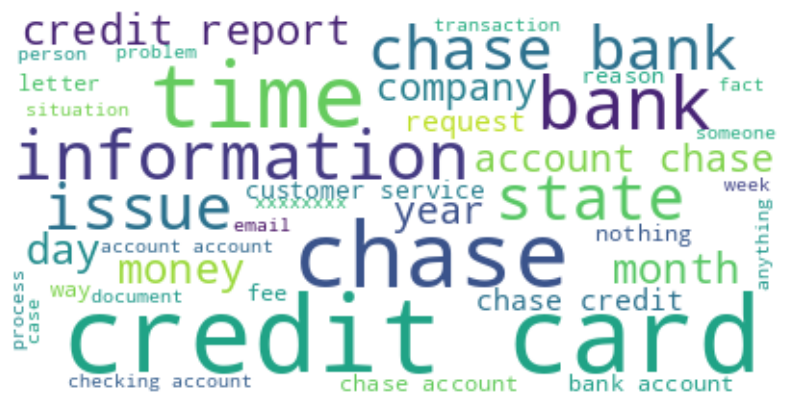

In [32]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

# Join all the complaints into a single string
all_complaints = " ".join(complaint for complaint in df_clean['complaint_POS_removed'])

# Create the word cloud
wordcloud = WordCloud(max_words=40, background_color="white").generate(all_complaints)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean['Complaint_clean']

,Complaint_clean
1,morning name stop service debt verification st...
2,card agent anniversary date agent information ...
10,chase card report application identity consent...
11,ticket offer ticket reward card information of...
14,son chase account fund chase bank account mone...
...,...
78303,chase card customer decade solicitation credit...
78309,credit card provider claim purchase protection...
78310,pay risk consumer chase bank app chase year ba...
78311,credit chase credit card chase freedom problem...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [34]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_clean['Complaint_clean'], 30)
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df_unigram

,unigram,count
0,chase,60052
1,account,47223
2,credit,33486
3,card,30264
4,bank,21611
5,payment,21152
6,time,16007
7,charge,14740
8,day,12936
9,money,11929


In [35]:
fig = go.Figure(go.Bar(
    x=df_unigram['count'],
    y=df_unigram['unigram'],
    orientation='h'
))

fig.update_layout(
    title="Top 30 Unigrams",
    xaxis_title="Count",
    yaxis_title="Unigram",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [36]:
#Print the top 10 words in the unigram frequency


In [ ]:
df_unigram.head(10)

,unigram,count
0,chase,60052
1,account,47223
2,credit,33486
3,card,30264
4,bank,21611
5,payment,21152
6,time,16007
7,charge,14740
8,day,12936
9,money,11929


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).


In [40]:
common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df_bigram

,bigram,count
0,credit card,12846
1,chase bank,4006
2,credit report,3950
3,account chase,3568
4,chase credit,3198
5,customer service,3066
6,chase account,2892
7,account account,2499
8,bank account,2473
9,checking account,2423


In [39]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [45]:
common_words = get_top_n_trigram(df_clean['Complaint_clean'], 30)
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df_trigram

,trigram,count
0,chase credit card,2162
1,credit card account,1106
2,credit card company,997
3,credit card chase,838
4,chase customer service,620
5,credit card credit,529
6,inquiry credit report,517
7,chase bank account,437
8,account credit card,435
9,charge credit card,419


In [41]:
common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure(go.Bar(
    x=df_bigram['count'],
    y=df_bigram['bigram'],
    orientation='h'
))

fig.update_layout(
    title="Top 30 Bigrams",
    xaxis_title="Count",
    yaxis_title="Bigram",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [ ]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12846
1,chase bank,4006
2,credit report,3950
3,account chase,3568
4,chase credit,3198
5,customer service,3066
6,chase account,2892
7,account account,2499
8,bank account,2473
9,checking account,2423


In [46]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 10)
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df_bigram

,bigram,count
0,credit card,12846
1,chase bank,4006
2,credit report,3950
3,account chase,3568
4,chase credit,3198
5,customer service,3066
6,chase account,2892
7,account account,2499
8,bank account,2473
9,checking account,2423


In [47]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [48]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
common_words = get_top_n_trigram(df_clean['Complaint_clean'], 30)
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df_trigram

,trigram,count
0,chase credit card,2162
1,credit card account,1106
2,credit card company,997
3,credit card chase,838
4,chase customer service,620
5,credit card credit,529
6,inquiry credit report,517
7,chase bank account,437
8,account credit card,435
9,charge credit card,419


In [49]:
common_words = get_top_n_trigram(df_clean['Complaint_clean'], 30)
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure(go.Bar(
    x=df_trigram['count'],
    y=df_trigram['trigram'],
    orientation='h'
))

fig.update_layout(
    title="Top 30 Trigrams",
    xaxis_title="Count",
    yaxis_title="Trigram",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [50]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2162
1,credit card account,1106
2,credit card company,997
3,credit card chase,838
4,chase customer service,620
5,credit card credit,529
6,inquiry credit report,517
7,chase bank account,437
8,account credit card,435
9,charge credit card,419


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [51]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [53]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


In [52]:
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



In [54]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [55]:
display(df_clean.head())
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


In [56]:
# Examine the df_clean dataframe before dropping NaN values
display(df_clean.head())

# Remove NaN values from the 'Complaint_clean' column
df_clean.dropna(subset=['Complaint_clean'], inplace=True)

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [57]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [86]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40 and increase max_iter
nmf_model = NMF(n_components=num_topics, random_state=40, max_iter=500)

In [87]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 500 reached. Increase it to improve convergence.



6768

In [60]:
tfidf.fit(df_clean['Complaint_clean'])
len(tfidf.get_feature_names_out())

6768

In [61]:
# Print the Top 15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'business', 'number', 'transaction', 'checking', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['company', 'statement', 'time', 'balance', 'merchant', 'fraud', 'service', 'purchase', 'transaction', 'fee', 'dispute', 'credit', 'chase', 'charge', 'card']


THE TOP 15 WORDS FOR TOPIC #2
['request', 'sale', 'house', 'foreclosure', 'rate', 'document', 'time', 'letter', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC #3
['bureau', 'limit', 'identity', 'application', 'chase', 'reporting', 'information', 'debt', 'company', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


THE TOP 15 WORDS FOR TOPIC #4
['error', 'mortgage', 'year', 'account', 'credit', 'date', 'chase', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']




In [62]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 1, 3, ..., 1, 4, 4])

In [63]:
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


In [64]:
df_clean['Topic'] = topic_results.argmax(axis=1)

In [ ]:
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,NaN,NaN,NaN,NaN,2
1,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,3
3,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,0


In [65]:
#Print the first 5 Complaint for each of the Topics
df_grouped = df_clean.groupby('Topic').head(5)
df_grouped.sort_values('Topic')

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,mishandle account auto,0
35,i opened the saving account for the bonus i w...,I open the save account for the bonus I be s...,save account bonus bonus auto transfer check t...,save account bonus bonus auto transfer check t...,0
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer use chase pay chase website s...,payment retailer use chase pay chase website s...,1
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charge wrong...,concern charge overdraft fee alert balance uns...,concern charge overdraft fee alert balance uns...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card decline catering order place...,chase amazon card decline catering order place...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card charge b...,sofa love seat table chair debit card charge b...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [66]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank Account services",
                1:"Credit card or prepaid card",
                2:"Mortgage/Loan",
                3:"Theft/Dispute Reporting",
                4:"Others"
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [67]:
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card or prepaid card
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,Others


In [68]:
df_clean['Topic']

,Topic
1,Mortgage/Loan
2,Credit card or prepaid card
10,Theft/Dispute Reporting
11,Theft/Dispute Reporting
14,Bank Account services
...,...
78303,Credit card or prepaid card
78309,Credit card or prepaid card
78310,Credit card or prepaid card
78311,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [78]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":0,
                "Credit card or prepaid card":1,
                "Mortgage/Loan":2,
                "Theft/Dispute Reporting":3,
                "Others":4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [70]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [71]:
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,NaN
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,NaN
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,NaN
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,NaN
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,NaN
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,NaN
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,NaN
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,NaN
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,NaN


In [79]:
#Keep the columns"complaint" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[df_clean['complaint'].notna()][['complaint', 'Topic']]

In [73]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,NaN
2,i upgraded my xxxx xxxx card in and was told ...,NaN
10,chase card was reported on however fraudulent...,NaN
11,on while trying to book a xxxx xxxx ticket ...,NaN
14,my grand son give me check for i deposit it i...,NaN
...,...,...
78303,after being a chase card customer for well ove...,NaN
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,NaN
78310,i am not familiar with xxxx pay and did not un...,NaN
78311,i have had flawless credit for yrs ive had ch...,NaN


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Write your code here to build any 3 models and evaluate them using the required metrics

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- Re-create Topic Assignments correctly ---
# Assign the integer topics from the NMF model output
df_clean['Topic'] = topic_results.argmax(axis=1)

# --- Data Preparation ---
# We will use the cleaned text ('Complaint_clean') and the integer 'Topic'
# Drop rows where either of these is missing
training_data = df_clean.dropna(subset=['Complaint_clean', 'Topic'])

# Also, remove any rows where the complaint text is just whitespace.
training_data = training_data[training_data['Complaint_clean'].str.strip() != '']

# Ensure the 'Topic' column is of integer type for the models.
training_data['Topic'] = training_data['Topic'].astype(int)

# Check if the training data is empty before proceeding.
if training_data.empty:
    print("Error: The training data is still empty. There might be an issue with the topic modeling results.")
else:
    print(f"Created training data with {len(training_data)} rows.")
    # Create the vector counts using Count Vectoriser on the cleaned complaints
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(training_data['Complaint_clean'])

    # Transform the word vector to tf-idf
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    # Create the train & test data
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42
    )

    # --- Model Training and Evaluation ---

    # Model 1: Logistic Regression
    print("\n--- Logistic Regression ---")
    lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
    lr_classifier.fit(X_train, y_train)
    y_pred_lr = lr_classifier.predict(X_test)
    print(classification_report(y_test, y_pred_lr, zero_division=0))

    # Model 2: Decision Tree
    print("\n--- Decision Tree ---")
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)
    y_pred_dt = dt_classifier.predict(X_test)
    print(classification_report(y_test, y_pred_dt, zero_division=0))

    # Model 3: Random Forest
    print("\n--- Random Forest ---")
    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)
    print(classification_report(y_test, y_pred_rf, zero_division=0))

Created training data with 21065 rows.

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1387
           1       0.96      0.97      0.97      1583
           2       0.94      0.96      0.95       952
           3       0.98      0.95      0.97       803
           4       0.97      0.92      0.95       542

    accuracy                           0.96      5267
   macro avg       0.96      0.96      0.96      5267
weighted avg       0.96      0.96      0.96      5267


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1387
           1       0.85      0.83      0.84      1583
           2       0.82      0.82      0.82       952
           3       0.81      0.80      0.80       803
           4       0.78      0.82      0.80       542

    accuracy                           0.83      5267
   macro avg       0.82      0.83      0

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Model Evaluation and Selection

Based on the classification reports for the three models, we can evaluate their performance and select the best one.

**1. Logistic Regression:**
*   **Accuracy:** 0.96 (96%)
*   **Precision, Recall, and F1-Score:** This model shows excellent and well-balanced performance across all topics, with most scores around 0.95-0.98. The macro and weighted averages are both 0.96, indicating strong, consistent performance.

**2. Decision Tree:**
*   **Accuracy:** 0.83 (83%)
*   **Precision, Recall, and F1-Score:** The scores are significantly lower than Logistic Regression, hovering around 0.82-0.83. This model is clearly less effective at classifying the complaints correctly.

**3. Random Forest:**
*   **Accuracy:** 0.87 (87%)
*   **Precision, Recall, and F1-Score:** While better than the Decision Tree, it is still outperformed by Logistic Regression. Notably, its performance on "Others" (class 4) is poor, with a recall of only 0.57 and an F1-score of 0.70. This means it struggles to correctly identify complaints belonging to this category.

**Conclusion:**

The **Logistic Regression model is the best-performing model**. It achieves the highest accuracy and demonstrates consistently high precision, recall, and F1-scores across all complaint categories. This makes it the most reliable and effective model for this classification task.